# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.



Данные геологоразведки трёх регионов находятся в файлах.
Значения полей:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

# Содержание

<b> [Часть 1. Изучение общей информации](#ch_1_1) <br>
<b> [Часть 2. Обучение и проверка моделей](#ch_2_1)<br>
<b> [Часть 3. Подготовка расчета прибыли](#ch_3_1)<br>
<b> [Часть 4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели](#ch_4_1)<br>
<b> [Часть 5. Расчет рисков и прибыли для каждого региона](#ch_5_1)<br>
<b> [Часть 6. Выводы](#ch_6_1)


## Загрузка и подготовка данных <a id='ch_1_1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')
display(df_1.describe())
display(df_2.describe())
display(df_3.describe())
print('shape df 1:',df_1.shape)
print('shape df 2:',df_2.shape)
print('shape df 3:',df_3.shape)
      


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


shape df 1: (100000, 5)
shape df 2: (100000, 5)
shape df 3: (100000, 5)


Пропусков в таблицах нет, при общем рассмотрении target имеет схожие характеристики в регионах 1 и 3, в регионе 2 значения ниже.

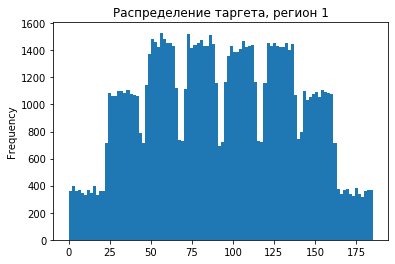

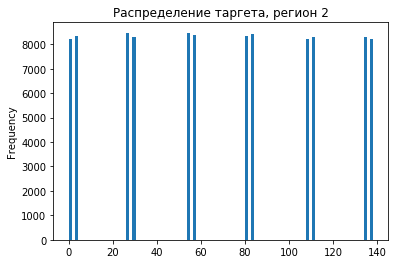

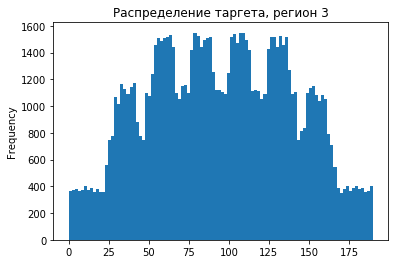

In [2]:
hist1 = plt.figure()
hist1 = df_1['product'].plot(kind ='hist',title = 'Распределение таргета, регион 1', bins = 100)
hist2 = plt.figure()
hist2 = df_2['product'].plot(kind ='hist',title = 'Распределение таргета, регион 2',  bins = 100)
hist3 = plt.figure()
hist3 = df_3['product'].plot(kind ='hist',title = 'Распределение таргета, регион 3',  bins = 100)



Распределение целевой переменной во втором регионе крайне странное! Если для 1 и 3 еще есть какая скученность ближе к центру, у второго всё равномерно.

## Обучение и проверка модели <a id='ch_2_1'></a>

Построим для регионов модель линейной регресии, предварительно разделив датафрейм на тренировочную и валидационную выборки.

In [3]:
df_1_features = df_1.drop(['id', 'product'], axis = 1)
df_1_target = df_1['product']
features_train_1, features_valid_1, target_train_1, target_valid_1 = \
    train_test_split(df_1_features, df_1_target, test_size = 0.25, random_state = 42)
model = LinearRegression()
model.fit(features_train_1, target_train_1)
prediction_valid_1 = model.predict(features_valid_1)
print('Регион 1')
print('Среднее значение предсказаний:',prediction_valid_1.mean())
print('RMSE:', mean_squared_error(target_valid_1, prediction_valid_1)**0.5)
print('R2:', r2_score(target_valid_1, prediction_valid_1))
print('MAE:', mean_absolute_error(target_valid_1, prediction_valid_1))

Регион 1
Среднее значение предсказаний: 92.39879990657768
RMSE: 37.75660035026169
R2: 0.2728287328173471
MAE: 31.047681538788183


In [4]:
df_2_features = df_2.drop(['id', 'product'], axis = 1)
df_2_target = df_2['product']
features_train_2, features_valid_2, target_train_2, target_valid_2 = \
    train_test_split(df_2_features, df_2_target, test_size = 0.25, random_state = 42)
model = LinearRegression()
model.fit(features_train_2, target_train_2)
prediction_valid_2 = model.predict(features_valid_2)
print('Регион 2')
print('Среднее значение предсказаний:',prediction_valid_2.mean())
print('RMSE:', mean_squared_error(target_valid_2, prediction_valid_2)**0.5)
print('R2:', r2_score(target_valid_2, prediction_valid_2))
print('MAE:', mean_absolute_error(target_valid_2, prediction_valid_2))

Регион 2
Среднее значение предсказаний: 68.71287803913764
RMSE: 0.8902801001028828
R2: 0.9996245232002449
MAE: 0.7170119535682544


In [5]:
df_3_features = df_3.drop(['id', 'product'], axis = 1)
df_3_target = df_3['product']
features_train_3, features_valid_3, target_train_3, target_valid_3 = \
    train_test_split(df_3_features, df_3_target, test_size = 0.25, random_state = 42)
model = LinearRegression()
model.fit(features_train_3, target_train_3)
prediction_valid_3 = model.predict(features_valid_3)
print('Регион 3')
print('Среднее значение предсказаний:',prediction_valid_3.mean())
print('RMSE:', mean_squared_error(target_valid_3, prediction_valid_3)**0.5)
print('R2:', r2_score(target_valid_3, prediction_valid_3))
print('MAE:', mean_absolute_error(target_valid_3, prediction_valid_3))

Регион 3
Среднее значение предсказаний: 94.77102387765939
RMSE: 40.145872311342174
R2: 0.19634705977280487
MAE: 32.896958610578054


Модели для первого и третьего региона получились низкого качества: ошибка довольно велика, коэффициент детерминации очень низок. А вот модель для второго региоа предсказывает данные практически идеально - при среднем значении в 68.7 RMSE меньше единицы, а R2 почти 0.9997. Это подозрительно хорошо!

Средний запас в скважине в регионах 1 и 3 значительно выше, чем во втором - разница почти 25%!

## Подготовка к расчёту прибыли <a id='ch_3_1'></a>

Рассчитаем средние запасы сырья в каждом регионе и сравним с объемом сырья для безубыточной разработки.

In [6]:
state = np.random.RandomState(42)
budget = 10000000000
wells_amnt = 200
profit_per_unit = 450000
target_profit = budget / wells_amnt / profit_per_unit
print('Средний запас сырья в регионе 1', df_1_target.mean())
print('Средний запас сырья в регионе 2', df_2_target.mean())
print('Средний запас сырья в регионе 3', df_3_target.mean())
print('Объем сырья для безубыточной разработки:',target_profit)

Средний запас сырья в регионе 1 92.50000000000001
Средний запас сырья в регионе 2 68.82500000000002
Средний запас сырья в регионе 3 95.00000000000004
Объем сырья для безубыточной разработки: 111.11111111111111


В целом, каждый из регионов по среднему показателю не подходит для безубыточной разработки. У регионов 1 и 3 разница с точкой безубыточности низка, у региона 2 около 40%, что существенно. Но это показатели это общих выборок, без ранжирования. Случайно выбрать скважину не получится - нужны лучшие! 

## Создание функции расчета прибыли <a id='ch_4_1'></a>

Созданную функцию протестируем на одном из регионов

In [7]:
def profit(target, prediction, count):
    prediction = pd.Series(prediction)
    target.reset_index(drop = True, inplace = True)
    pred_sorted = prediction.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return  selected.sum() * profit_per_unit - budget  
print(profit(target_valid_3, prediction_valid_3, 200))

2598571759.374111


Неплохая прибыль на полной выборке! Посмотрим, как поведет себя функция при бутсреппинге.

## Расчёт прибыли и рисков  <a id='ch_5_1'></a>

In [8]:
values_1 = []
values_2 = []
values_3 = []
prediction_valid_1 = pd.Series(prediction_valid_1)
prediction_valid_2 = pd.Series(prediction_valid_2)
prediction_valid_3 = pd.Series(prediction_valid_3)

for i in range(1000):
    subsample_1 = prediction_valid_1.sample(n = 500, random_state = state, replace = True)
    subsample_2 = prediction_valid_2.sample(n = 500, random_state = state, replace = True)
    subsample_3 = prediction_valid_3.sample(n = 500, random_state = state, replace = True)
    values_1.append(profit(target_valid_1, subsample_1, 200))
    values_2.append(profit(target_valid_2, subsample_2, 200))
    values_3.append(profit(target_valid_3, subsample_3, 200))
    
values_1 = pd.Series(values_1)
values_2 = pd.Series(values_2)
values_3 = pd.Series(values_3)

values_1_neg = values_1[values_1 < 0]
values_1_lower = values_1.quantile(0.025)
values_1_upper = values_1.quantile(0.975)

values_2_neg = values_2[values_2 < 0]
values_2_lower = values_2.quantile(0.025)
values_2_upper = values_2.quantile(0.975)

values_3_neg = values_3[values_3 < 0]
values_3_lower = values_3.quantile(0.025)
values_3_upper = values_3.quantile(0.975)

print('Средняя прибыль с топ-200 лучших случайных скважин, регион 1:',round(values_1.mean()))
print('95%-й доверительный интервал для региона 1:', round(values_1_lower), '-', round(values_1_upper))
print('Вероятность отрицательной прибыли в регионе 1:', len(values_1_neg)/len(values_1))
print('Средняя прибыль с топ-200 лучших случайных скважин, регион 2:',round(values_2.mean()))
print('95%-й доверительный интервал для региона 2:', round(values_2_lower), '-', round(values_2_upper))
print('Вероятность отрицательной прибыли в регионе 2:', len(values_2_neg)/len(values_2))
print('Средняя прибыль с топ-200 лучших случайных скважин, регион 3:',round(values_3.mean()))
print('95%-й доверительный интервал для региона 3:', round(values_3_lower), '-', round(values_3_upper))
print('Вероятность отрицательной прибыли в регионе 3:', len(values_3_neg)/len(values_3))

Средняя прибыль с топ-200 лучших случайных скважин, регион 1: 416344259
95%-й доверительный интервал для региона 1: -83266090 - 868690393
Вероятность отрицательной прибыли в регионе 1: 0.051
Средняя прибыль с топ-200 лучших случайных скважин, регион 2: 449665207
95%-й доверительный интервал для региона 2: 67459734 - 853702945
Вероятность отрицательной прибыли в регионе 2: 0.008
Средняя прибыль с топ-200 лучших случайных скважин, регион 3: 384343470
95%-й доверительный интервал для региона 3: -125173859 - 894297873
Вероятность отрицательной прибыли в регионе 3: 0.071


Согласно расчетам, каждый регион в среднем укладывается в бюджет по разработке скважин, хотя для всех трёх регионов есть вероятность получить убытки. Для региона 1 и 3 отрицательные значения лежат внутри 95% доверительного интервала, а получить убытки можно в 51 случае из 1000 и 71 случае из 1000 соответственно. У региона 2 ситуация немного лучше: в 95% доверительном интервале отрицательных значений нет, а получить убытки можно лишь в 8 случаях из 1000, что ниже порога 2.5%. К тому же, средняя прибыль в регионе 2 заметно выше остальных - выше более чем на 30 млн. по сравнению со вторым местом.

Таким образом, рекомендуемым и оптимальным для разработки является регион 2.
